<a href="https://colab.research.google.com/github/Gehlen05/Aprendizado-Maquina/blob/main/algoritmo-engenharia/lstm_enc_dec_att_fourier_alexsandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from foreblocks import TimeSeriesSeq2Seq, ModelConfig, TrainingConfig, AttentionLayer
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import matplotlib.pyplot as plt
from foreblocks import ForecastingModel
from foreblocks import LSTMDecoder, LSTMEncoder
from foreblocks import Trainer
from foreblocks.att import AttentionLayer
from foreblocks.blocks.fourier import FourierFeatures

# 1) Ler CSV
df = pd.read_csv("timeseries.csv")

# 1) Limpar possíveis sujeiras no campo time
df["time"] = df["time"].astype(str).str.strip()

# remover linhas claramente inválidas (como "202", "", None)
df = df[~df["time"].isin(["202", "NaT", "", "nan", "None"])]

# converter para datetime (coerce => vira NaT se for inválida)
df["time"] = pd.to_datetime(df["time"], errors="coerce")

# remover datas inválidas
df = df.dropna(subset=["time"])

# 2) Remover NaNs do y e das features importantes
cols_to_clean = ["y"]

df = df.dropna(subset=cols_to_clean)

# 3) Filtrar só série 0
df0 = df[df["series"] == 0].copy()

# 4) Garantir ordenação por tempo
df0 = df0.sort_values("time").reset_index(drop=True)

print(df0.head())
print(df0.shape)


   series       time          y
0       0 2020-01-01   9.531467
1       0 2020-01-02  10.397162
2       0 2020-01-03  10.808862
3       0 2020-01-04  10.914430
4       0 2020-01-05  10.474456
(1500, 3)


In [ ]:
# 3) Escolher as FEATURES de entrada
#    IMPORTANTE: y tem que ser a PRIMEIRA coluna
feature_cols = [
    "y"
]

X = df0[feature_cols].to_numpy(dtype=float)
print("data shape:", X.shape)  # (n_samples, n_features)

data shape: (1500, 1)


In [ ]:
n_features = X.shape[1]
hidden_size=64
output_size=n_features
num_layers=1
model_config = ModelConfig(
    model_type="lstm",
    input_size=n_features,
    output_size=n_features,
    hidden_size=64,
    target_len=12
)

attention = AttentionLayer(
    method="multiscale", # 'dot', 'mha', 'prob', 'temporal', 'multiscale', 'autocorr'
    encoder_hidden_size=64,
    decoder_hidden_size=64
)

training_config = TrainingConfig(
    num_epochs=300,          # 👈 número de épocas

)

encoder = LSTMEncoder(
    input_size=n_features,  # Now input size matches fourier output size
    hidden_size=hidden_size,
    num_layers=num_layers
)

decoder = LSTMDecoder(
    input_size=n_features,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers
)

fourier_preprocessor = FourierFeatures(
    input_size=n_features,          # Input dimension
    output_size=n_features,        # Output dimension (same as hidden_size)
    num_frequencies=16,             # Number of frequency components
    learnable=True,                 # Make frequency parameters learnable
    use_phase=False,                 # Include phase shifts
    use_gaussian=False,              # Use Gaussian random Fourier features (Rahimi & Recht)
)


[Attention] Method: multiscale, Backend: torch


In [ ]:
# Aqui só comentar os blocos que quer ou não. pode deixar só lstm e ir adc os blocos
model = TimeSeriesSeq2Seq(
    model_config=model_config,
    #attention_module=attention,
    encoder=encoder,
    decoder=decoder,
    training_config=training_config,
    input_preprocessor=fourier_preprocessor
)


📊 [Auto-Configuration]

+--------------------+----------------+
|     Parameter      | Configuration  |
+--------------------+----------------+
| Dataset Dimensions |    1500 × 1    |
|   Missing Values   |     0.00%      |
|    Stationarity    | Non-stationary |
|    Seasonality     |    Present     |
|   Transformation   |      None      |
| Signal Processing  |     savgol     |
|     Imputation     |  interpolate   |
| Outlier Detection  |     tranad     |
| Outlier Threshold  |      3.50      |
|   Decomposition    |    5 bands     |
+--------------------+----------------+
✅ Configuration complete.



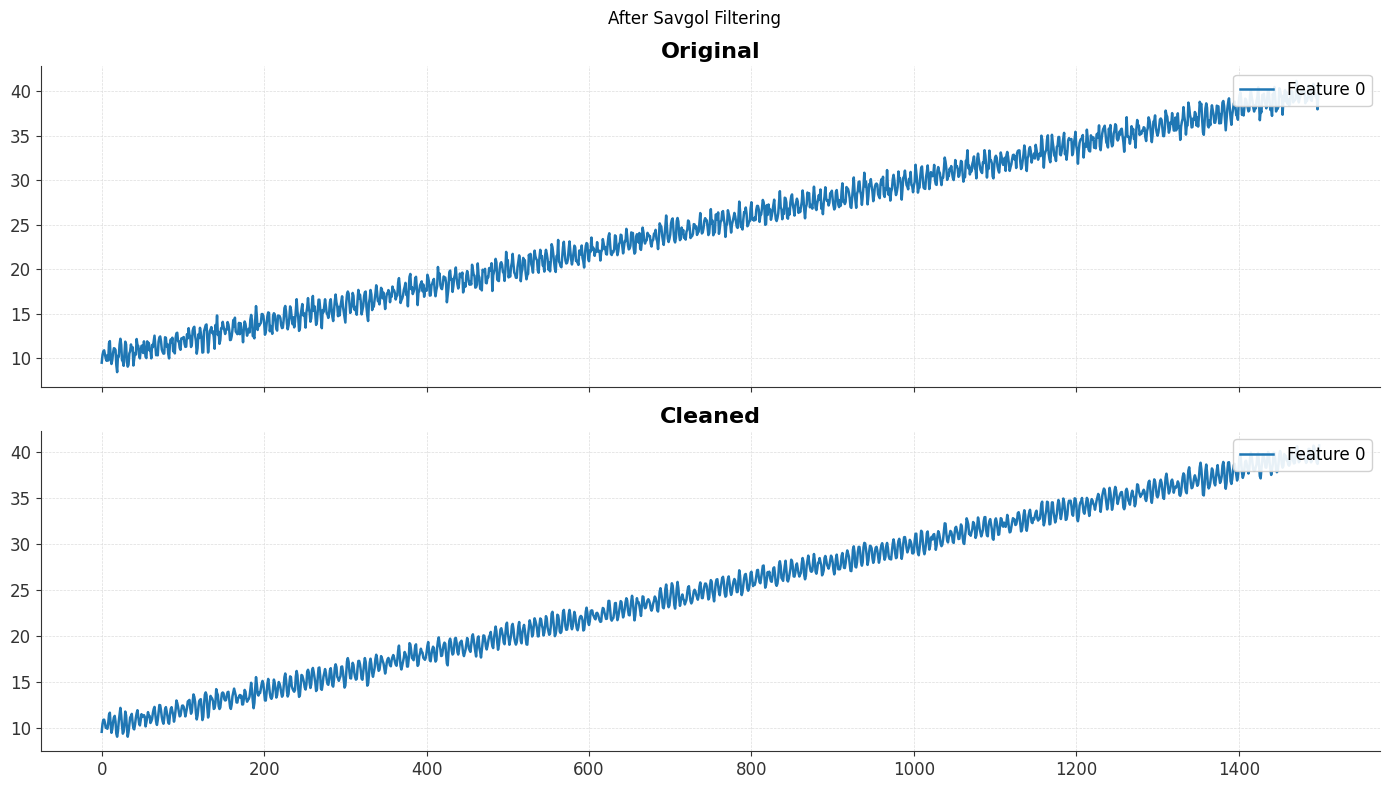

Creating sequences: 100%|██████████| 1425/1425 [00:00<00:00, 137295.46it/s]


In [ ]:
X_seq, y_seq, *_ = model.preprocess(
    X,
    normalize=True,
    differencing=True,
    detrend=True,
    apply_ewt=True,
    window_size=64,
    horizon=12,
    remove_outliers=False,
    outlier_method="iqr",
    self_tune=True,

)

#y_seq = y_seq[..., 0:1]   # mantém a dimensão 3D

In [ ]:
X_seq.shape

(1425, 64, 1)

In [ ]:
N = len(X_seq)

train_end = int(0.8 * N)

X_train = X_seq[:train_end]
y_train = y_seq[:train_end]

X_test  = X_seq[train_end:]
y_test  = y_seq[train_end:]


In [ ]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)


X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)


Training: 100%|██████████| 300/300 [10:00<00:00,  2.00s/epoch, epoch=300, train_loss=0.2312, lr=1.00e-03]


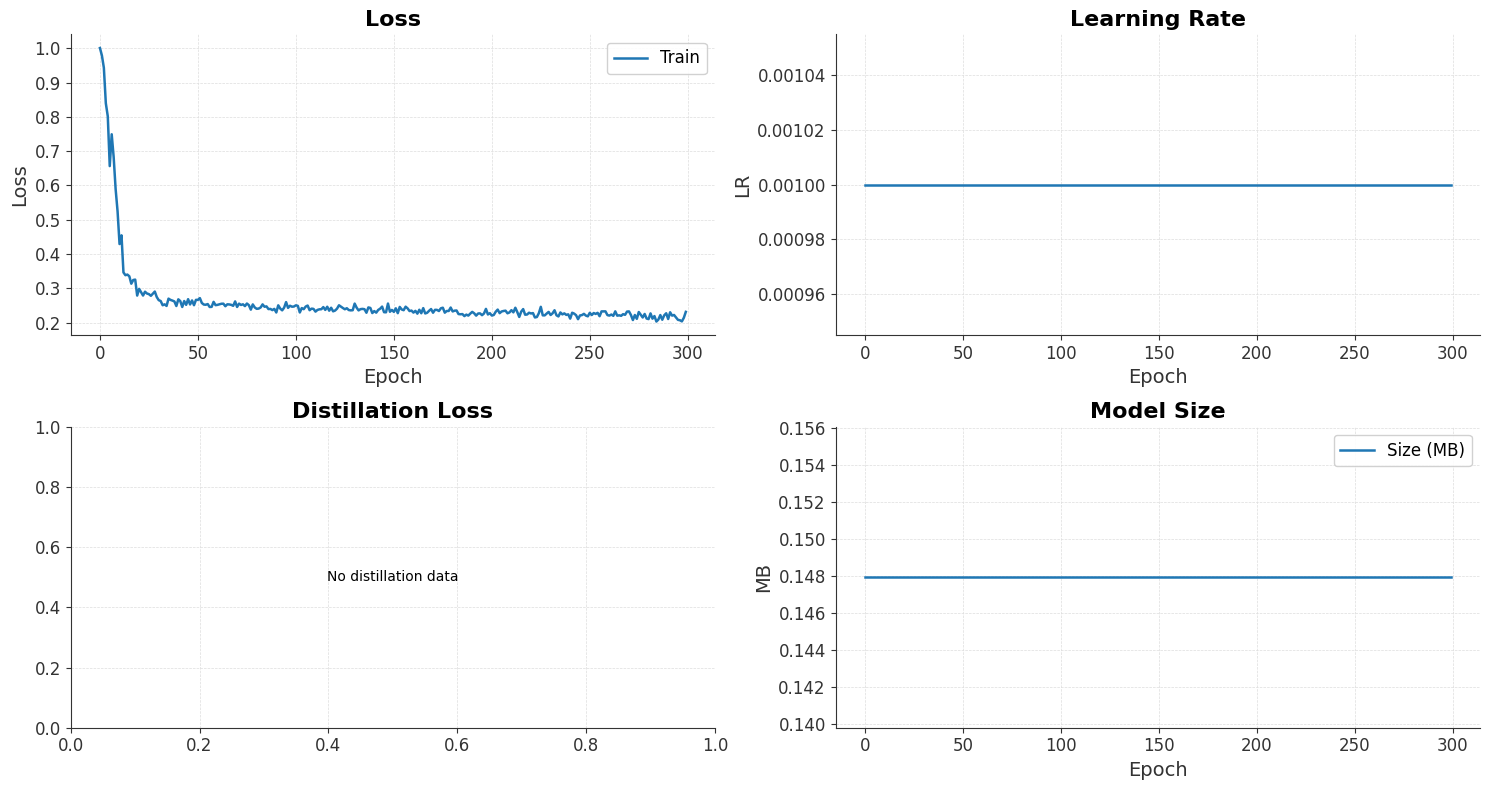

In [ ]:
history = model.train_model(train_loader)


In [ ]:
model.model.eval()  # dependendo da versão, pode ser model ou model.model
with torch.no_grad():
    y_val_pred = model.predict(X_test)


In [ ]:

# ---- y_true ----
if isinstance(y_test, torch.Tensor):
    y_true = y_test.detach().cpu().numpy().reshape(-1)
else:
    y_true = np.array(y_test).reshape(-1)

# ---- y_pred ----
if isinstance(y_val_pred, torch.Tensor):
    y_pred = y_val_pred.detach().cpu().numpy().reshape(-1)
else:
    y_pred = np.array(y_val_pred).reshape(-1)

# ---- Métricas ----
mse_val  = np.mean((y_true - y_pred)**2)
rmse_val = np.sqrt(mse_val)

print(f"MSE validação : {mse_val:.4f}")
print(f"RMSE validação: {rmse_val:.4f}")


MSE validação : 0.2828
RMSE validação: 0.5318


In [ ]:
# remover última dimensão se for (N, horizon, 1)
y_true = np.squeeze(y_true)  # vira (N, horizon)

# achatar tudo para um vetor
y_true_vec = y_true.reshape(-1)


In [ ]:

y_pred = np.squeeze(y_pred)
y_pred_vec = y_pred.reshape(-1)


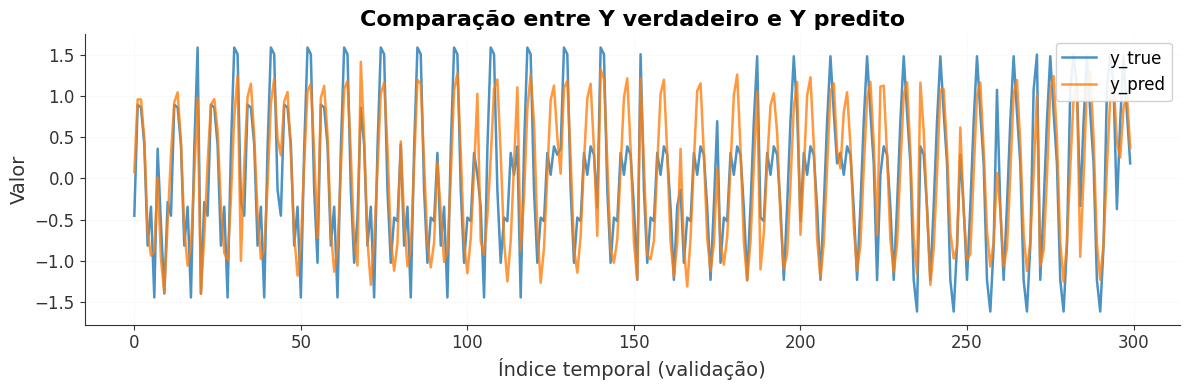

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_true_vec[700:1000], label="y_true", alpha=0.8)
plt.plot(y_pred_vec[700:1000], label="y_pred", alpha=0.8)
plt.title("Comparação entre Y verdadeiro e Y predito")
plt.xlabel("Índice temporal (validação)")
plt.ylabel("Valor")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


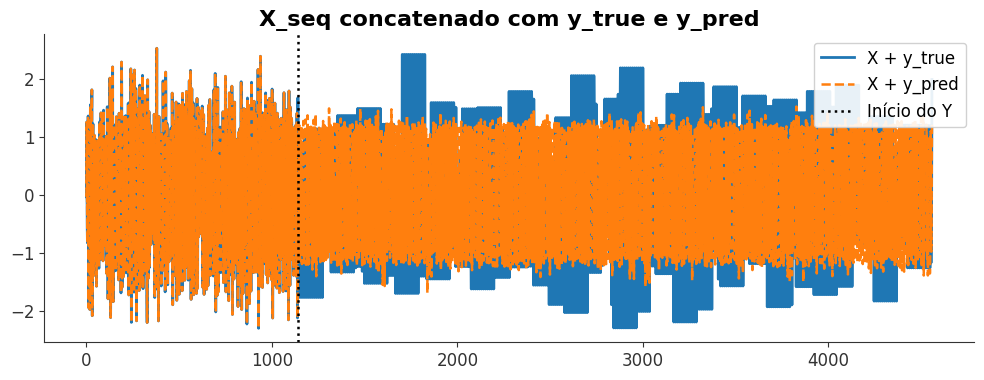

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# escolha da feature (se X_seq tiver 3D)
feature = 0

# sequência X completa até train_end
if X_seq.ndim == 3:
    x_plot = X_seq[:train_end, feature]
elif X_seq.ndim == 2:
    x_plot = X_seq[:train_end]
else:
    raise ValueError("Formato inesperado de X_seq")

# transformar em 1D para plot
x_plot = np.asarray(x_plot).reshape(-1)

# criar vector concatenado
joined_true  = np.concatenate([x_plot, y_true_vec])
joined_pred  = np.concatenate([x_plot, y_pred_vec])

plt.figure(figsize=(12,4))
plt.plot(joined_true, label="X + y_true", linewidth=2)
plt.plot(joined_pred, label="X + y_pred", linestyle="--")
plt.axvline(len(x_plot), color="black", linestyle=":", label="Início do Y")
plt.legend()
plt.grid()
plt.title("X_seq concatenado com y_true e y_pred")
plt.show()


In [ ]:
import numpy as np
import torch

def preparar_y(arr):
    # Converte para numpy
    if isinstance(arr, torch.Tensor):
        arr = arr.detach().cpu().numpy()
    else:
        arr = np.array(arr)

    # Casos comuns:
    # (batch, horizon, features) -> pega só a primeira feature
    if arr.ndim == 3:
        # batch, horizon, features
        arr = arr[:, :, 0]          # primeira feature

    # (batch, features) -> pega só a primeira feature
    elif arr.ndim == 2 and arr.shape[1] > 1:
        arr = arr[:, 0]             # primeira feature

    # Agora achata tudo para 1D
    return arr.reshape(-1)


In [ ]:
model.model.eval()  # dependendo da versão, pode ser model ou model.model
with torch.no_grad():
    y_val_pred = model.predict(X_test)

# ---- y_true e y_pred ajustados só com y ----
y_true = preparar_y(y_test)
y_pred = preparar_y(y_val_pred)

# ---- Métricas ----
mse_val  = np.mean((y_true - y_pred) ** 2)
rmse_val = np.sqrt(mse_val)

print(f"MSE validação : {mse_val:.4f}")
print(f"RMSE validação: {rmse_val:.4f}")


MSE validação : 0.2828
RMSE validação: 0.5318


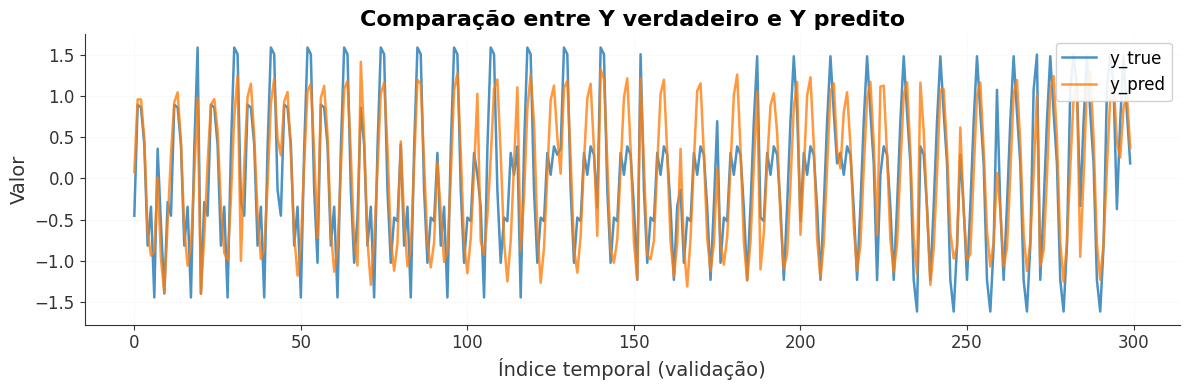

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(y_true_vec[700:1000], label="y_true", alpha=0.8)
plt.plot(y_pred_vec[700:1000], label="y_pred", alpha=0.8)
plt.title("Comparação entre Y verdadeiro e Y predito")
plt.xlabel("Índice temporal (validação)")
plt.ylabel("Valor")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


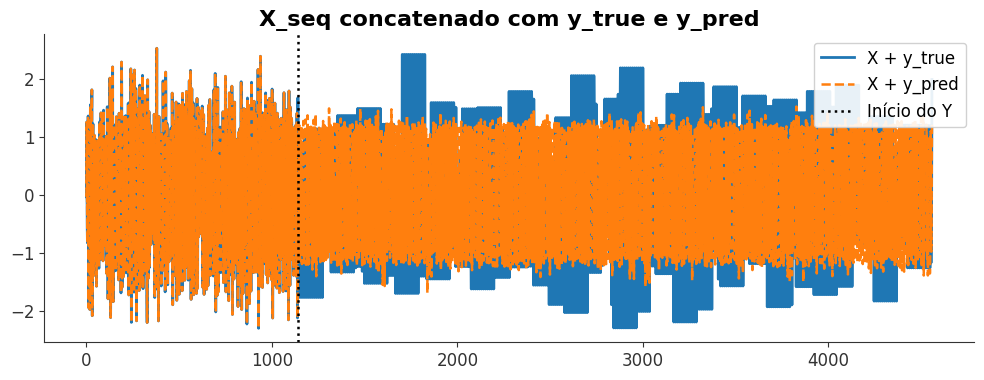

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# escolha da feature (se X_seq tiver 3D)
feature = 0

# sequência X completa até train_end
if X_seq.ndim == 3:
    x_plot = X_seq[:train_end, feature]
elif X_seq.ndim == 2:
    x_plot = X_seq[:train_end]
else:
    raise ValueError("Formato inesperado de X_seq")

# transformar em 1D para plot
x_plot = np.asarray(x_plot).reshape(-1)

# criar vector concatenado
joined_true  = np.concatenate([x_plot, y_true_vec])
joined_pred  = np.concatenate([x_plot, y_pred_vec])

plt.figure(figsize=(12,4))
plt.plot(joined_true, label="X + y_true", linewidth=2)
plt.plot(joined_pred, label="X + y_pred", linestyle="--")
plt.axvline(len(x_plot), color="black", linestyle=":", label="Início do Y")
plt.legend()
plt.grid()
plt.title("X_seq concatenado com y_true e y_pred")
plt.show()
